In [1]:
# illustrative example of use VeraRubin 

## Making a custom coadd

> Version: 1.0
> 
> Container Size: Large

> Description:  In this notebook, we present an illustrative example of using the injection functions from the VeraRubin package.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Loading modules
import numpy as np
import VeraRubin as vr
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.io import fits
#from astropy.wcs import WCS
#from astropy.coordinates import SkyCoord

#### Making a butler instance

In [4]:
butler = vr.ExpButler(info=False).butler  # using default adress

In [5]:
# Defining the sky coordinates and the selected band
ra_deg, dec_deg = (53.2, -27.8)  # RA, Dec
loc_data = (ra_deg, dec_deg)
band = 'u'

# Opening the FITS file
stamp_paths = ['stamp/PGC_038749_I_g_bbl2011_original.fits']

# Defining the properties of the stamp
mags = [14.8]  # Magnitude used to inject the stamp

# Sky position of the injection
ra_list, dec_list = [ra_deg], [dec_deg]

In [6]:
injected_exposure = vr.main_inject_stamp(
        butler, 
        loc_data,
        band,
        stamp_paths,
        mags,
        ra_list,
        dec_list,
        sky_coordinates=True,
        use_patch_area=False,
        detectors=None,
        timespan=None,
        visit_ids= None, # [2024113000172], 
        num_select=3, 
        min_sep=0.0005,
        separation_spherical=True,
        keep_size=False,
        interp_order=3,
        update_wcs=False,
        c=1,
        info_save_path='test/save_test',
        rot_name_save="test/stamp_rotated",
        remove_rotated_stamps= True,
        info=True)

[INFO] Injection on sky coordinates: RA=53.2, Dec=-27.8
[INFO] Found 31 visits for band=u
END: Collect visit exposures and getWcs info
Execution time: 104.508 seconds
[INFO] Using 3 visits after sorting and selection.
[INFO] Computed 3 rotation angles.


[INFO] Injection complete.


#### test

In [40]:
# First test
with fits.open(stamp_paths[0]) as hdul:
    data = hdul[0].data  # Give the pixels of the first extension
    hdr = hdul[0].header.copy()
    print(hdul.info())
    if "MASK" in [hdu.name for hdu in hdul]:
        mask = hdul["MASK"].data.astype(bool)
    else:
        mask = np.isfinite(data)  # check if the mask is identify by NaN value

Filename: stamp/PGC_038749_I_g_bbl2011_original.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (255, 255)   float32   
None


In [34]:
# Second test
mi = injected_exposure[0].getMaskedImage()

image_array = mi.getImage().getArray()
mask_array = mi.getMask().getArray()
variance_array = mi.getVariance().getArray()

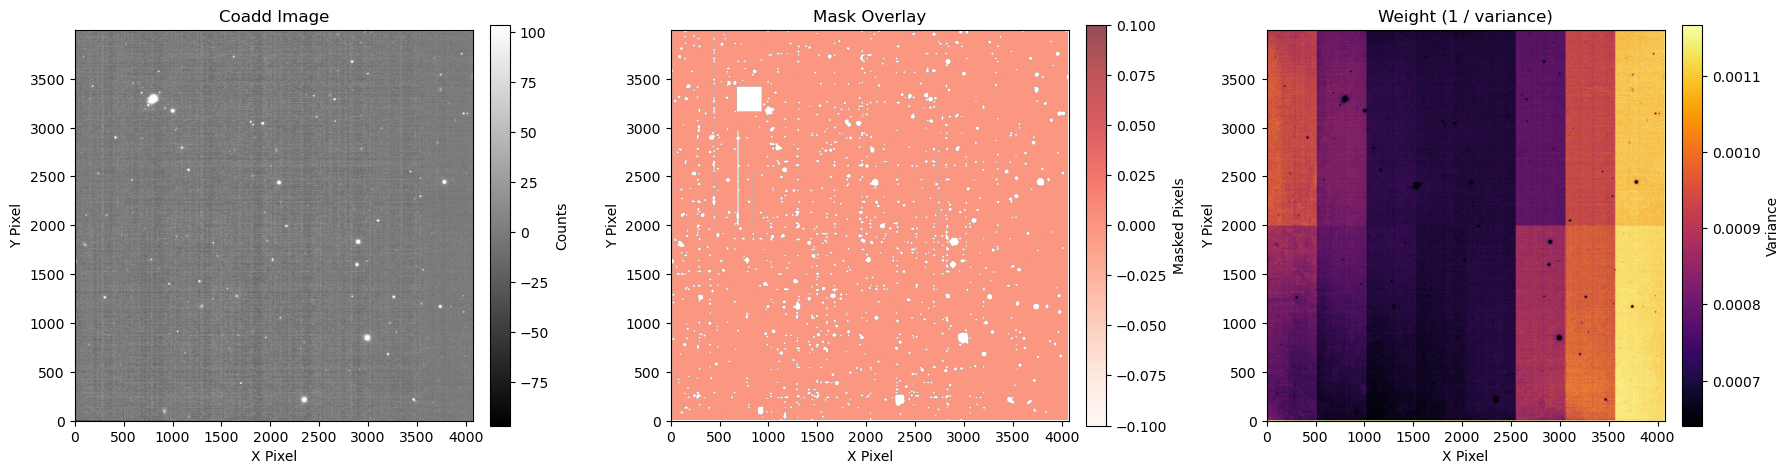

In [35]:
# Visualizating the image, mask and Weight
weight = 1.0/variance_array  # weight = 1/variance

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# coadd
im0 = axes[0].imshow(image_array, origin='lower', cmap='gray', vmin=np.percentile(image_array, 0.5), vmax=np.percentile(image_array, 99.5))
axes[0].set_title('Coadd Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Counts")

# Mask
fil = mask_array == 0
im1 = axes[1].imshow(np.where(fil, mask_array, np.nan), origin='lower', cmap='Reds', alpha=0.7)
axes[1].set_title("Mask Overlay")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Masked Pixels")

# Weight
im2 = axes[2].imshow(weight, origin='lower', cmap='inferno', vmin=np.percentile(weight, 5), vmax=np.percentile(weight, 95))
axes[2].set_title('Weight (1 / variance)')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Variance")

for ax in axes:
    ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")

plt.tight_layout()
plt.show()

#### Some plots

In [7]:
# Loading info
info_txt_path = 'test/save_test.txt'
with open(info_txt_path, "r") as f:
    info = json.load(f)

In [9]:
# Info
visit_name = info['Parameters']['visit_name']
points = info['Parameters']['points']
visits = info['data_Id']

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


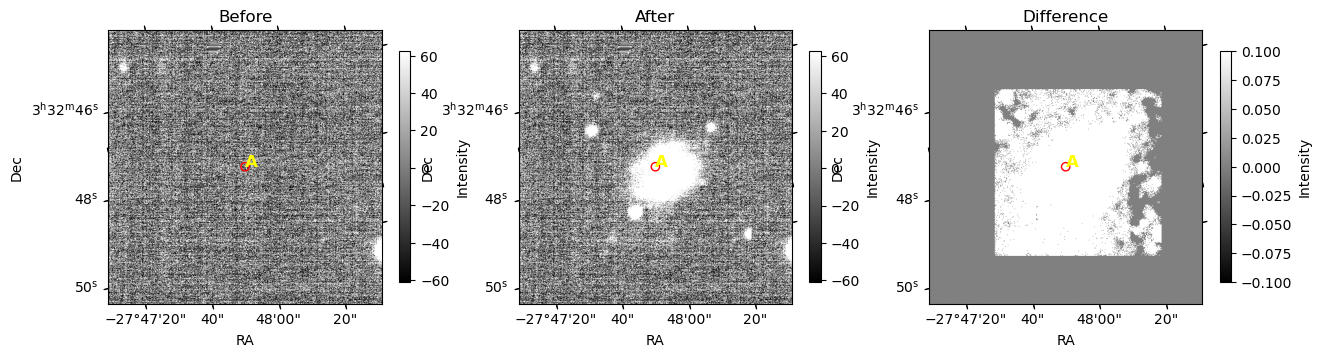

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:169: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


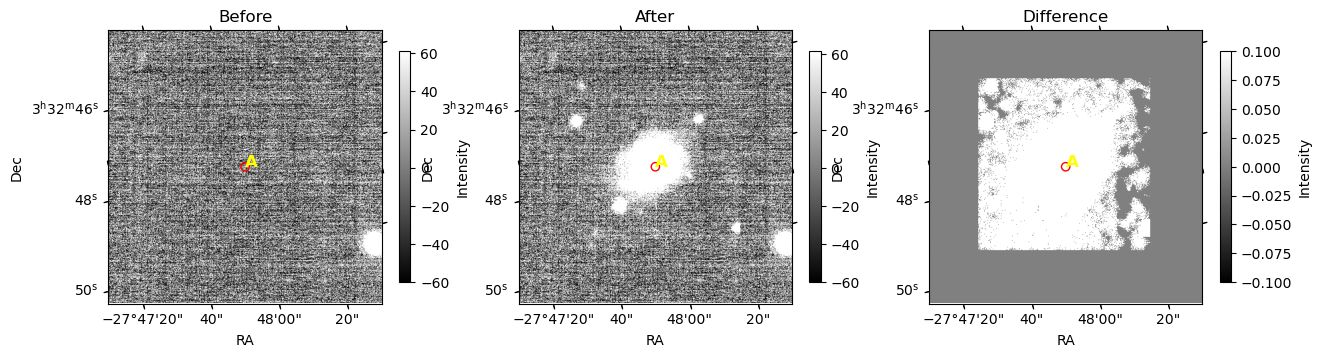

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


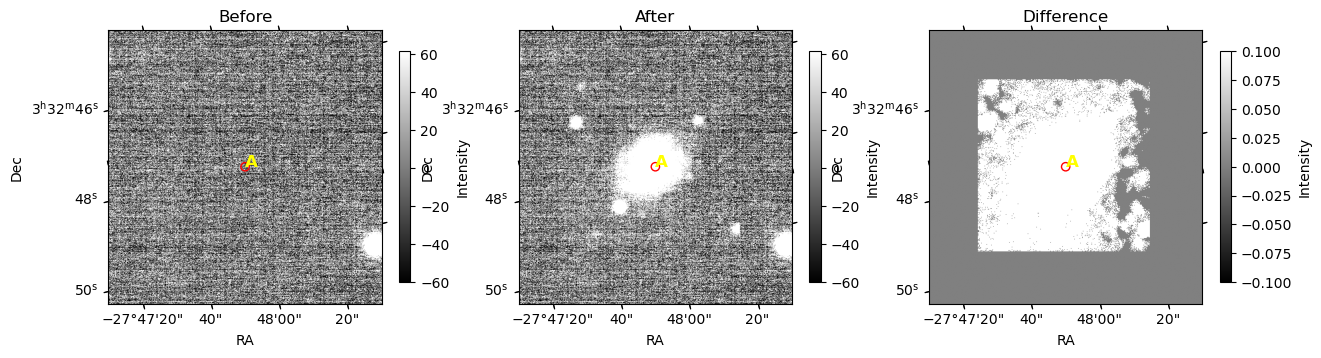

In [10]:
for i in range(len(visits)):
    before = butler.get(visit_name, dataId=visits[str(i)]['dataId'])
    after = injected_exposure[i]
    vr.injection_steps(before, after, points,
                       diference=True,
                       cutout_radius_arcsec=10,  # arcsec 
                       grid=False, percentiles=[5, 95])

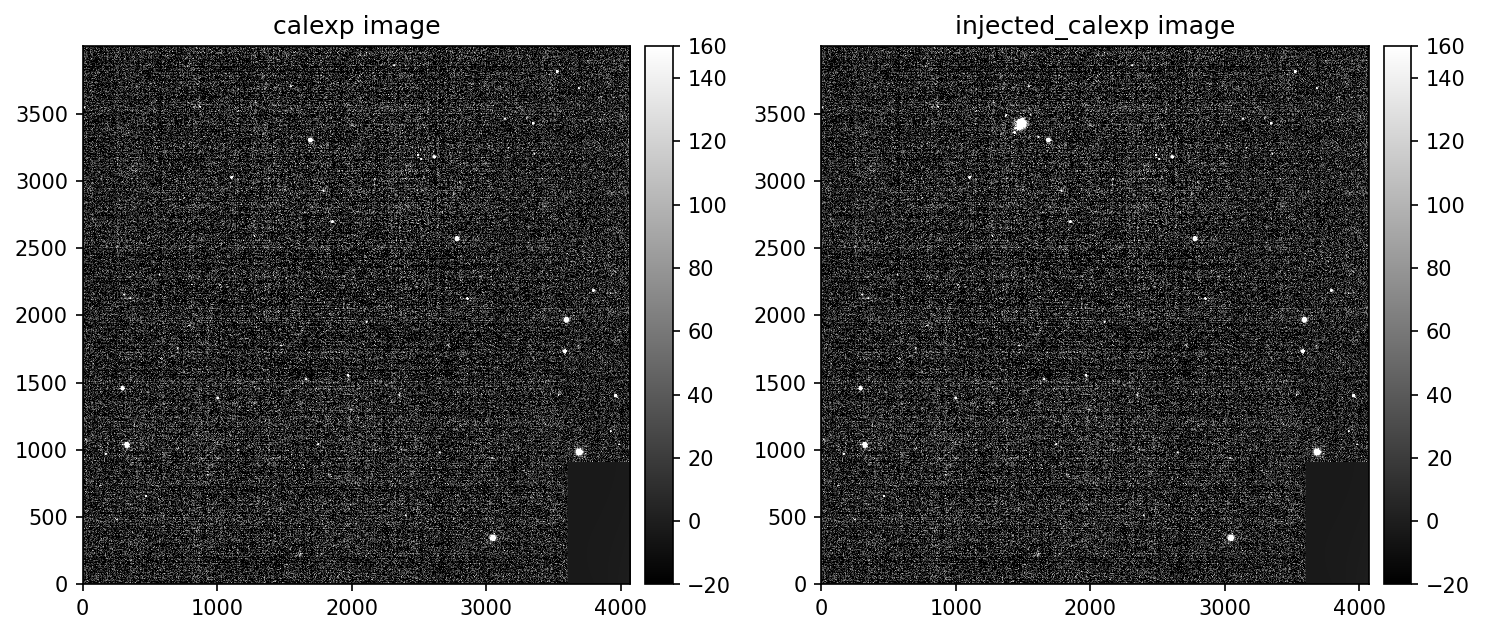

In [11]:
# Other option
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")

num = 2
visit_img = butler.get('visit_image', dataId=visits[str(num)]['dataId'])
plot_injected_img = injected_exposure[num].clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
# display0.scale('linear', 'zscale')
display0.scale('linear', min=-20, max=150)
display0.mtv(visit_img.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
# display1.scale('linear', 'zscale')
display1.scale('linear', min=-20, max=150)
display1.mtv(plot_injected_img.image)
# To zoom on the PGC 038749 stamp:
# display1.mtv(plot_injected_img.image[1700:2200, 1950:2450])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

### Making a coadd 

In [25]:
# exposures_list = ["visit1.fits", "visit2.fits", exposure_obj3]
# exposures = load_exposures(exposures_list)
coadded_exp = vr.coadd_exposures_pipeline(
    injected_exposure,
    ref_exp=None,
    warping_kernel="lanczos4",  # "lanczos3"
    save_path="./coadds",
    coadd_name=f"band_{band}_coadd.fits")

Progress: [####################] 100%
[INFO] LSST-style coadd saved to ./coadds/band_u_coadd.fits


In [26]:
# Loading the Exposure Coadd
from lsst.afw.image import ExposureF

coadd_exp = ExposureF.readFits(f"./coadds/band_{band}_coadd.fits")

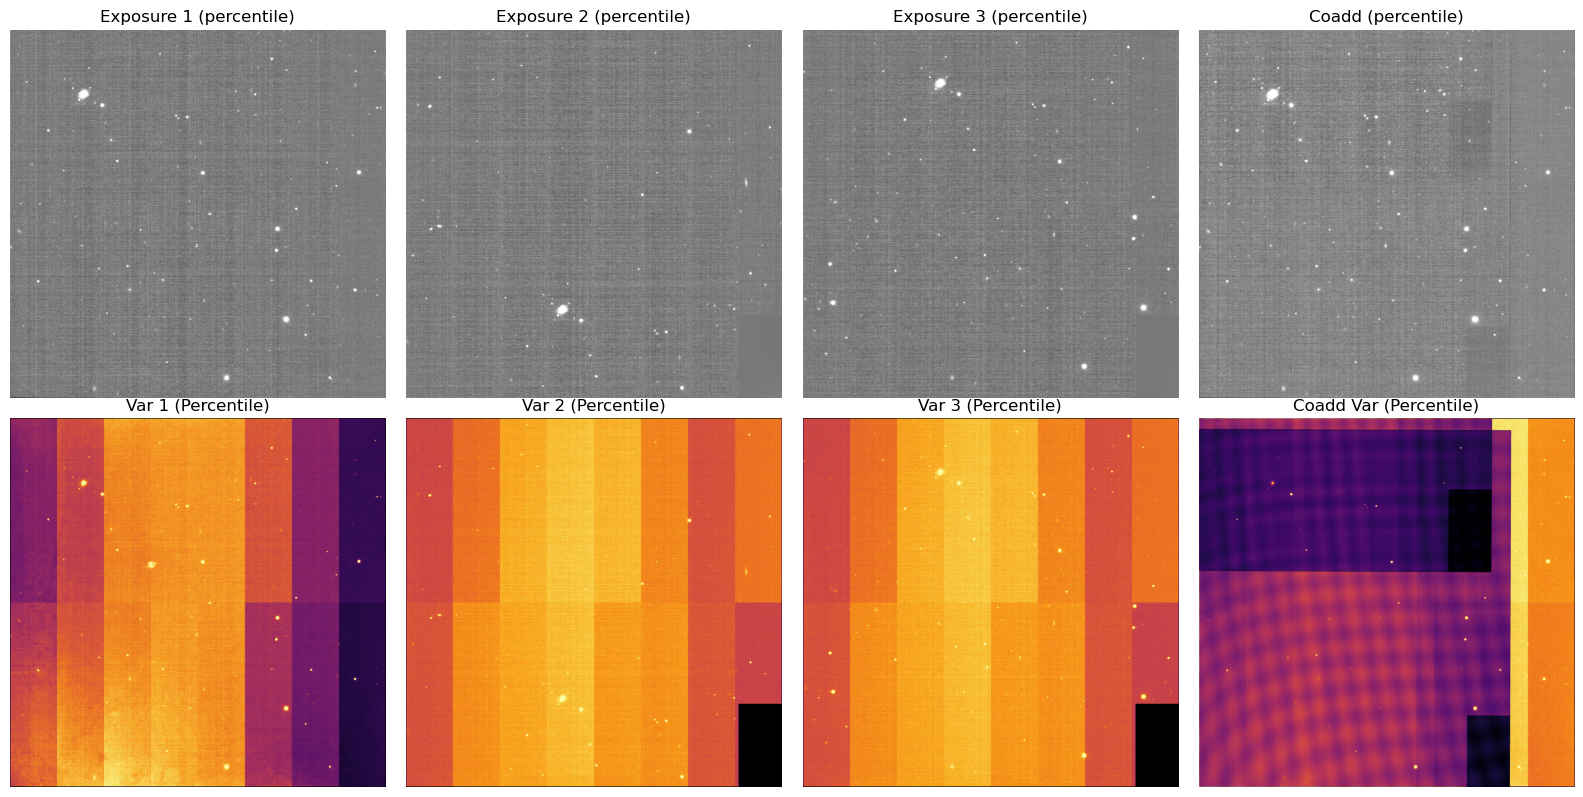

In [41]:
# Visualizing the result 
vr.plot_exposures_and_coadd(injected_exposure,
                         coadd_exp,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=True,
                         save_path=None)

In [28]:
# Accessing the image, mask, and variance info
mi = coadd_exp.getMaskedImage()

image_array = mi.getImage().getArray()
mask_array = mi.getMask().getArray()
variance_array = mi.getVariance().getArray()

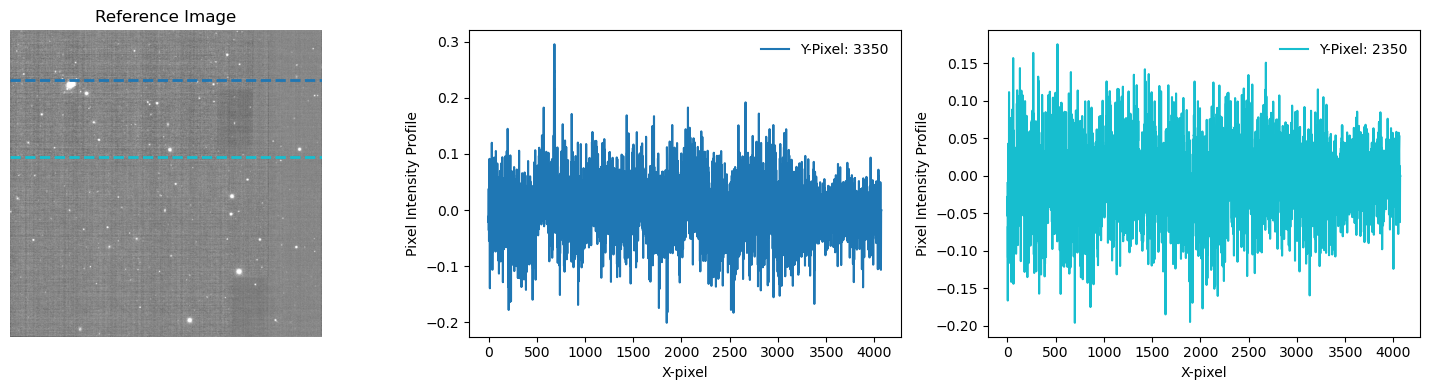

In [29]:
# Pixel intensity at some y_pixel position
y_positions_pixel = [3350, 2350]
vr.pixel_intensity(image_array,
                   y_positions_pixel,
                   image_ref=True,
                   save_path=None)

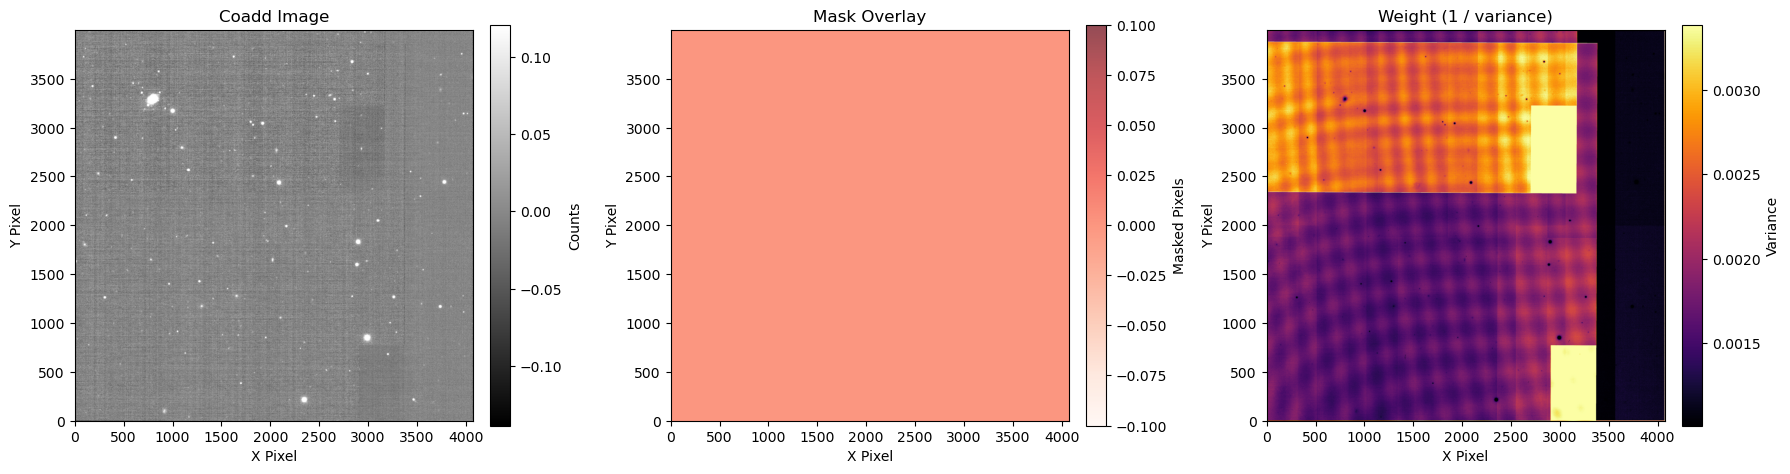

In [33]:
# Visualizating the image, mask and Weight
weight = 1.0/variance_array  # weight = 1/variance

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# coadd
im0 = axes[0].imshow(image_array, origin='lower', cmap='gray', vmin=np.percentile(image_array, 0.5),
                     vmax=np.percentile(image_array, 99.5))
axes[0].set_title('Coadd Image')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Counts")

# Mask
fil = mask_array == 0
im1 = axes[1].imshow(np.where(fil, mask_array, np.nan), origin='lower', cmap='Reds', alpha=0.7)
# im1 = axes[1].imshow(mask_array, origin='lower', cmap='Reds', alpha=0.7)
axes[1].set_title("Mask Overlay")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Masked Pixels")

# Weight
im2 = axes[2].imshow(weight, origin='lower', cmap='inferno', vmin=np.percentile(weight, 5), vmax=np.percentile(weight, 95))
axes[2].set_title('Weight (1 / variance)')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Variance")

for ax in axes:
    ax.set_xlabel("X Pixel")
    ax.set_ylabel("Y Pixel")

plt.tight_layout()
plt.show()

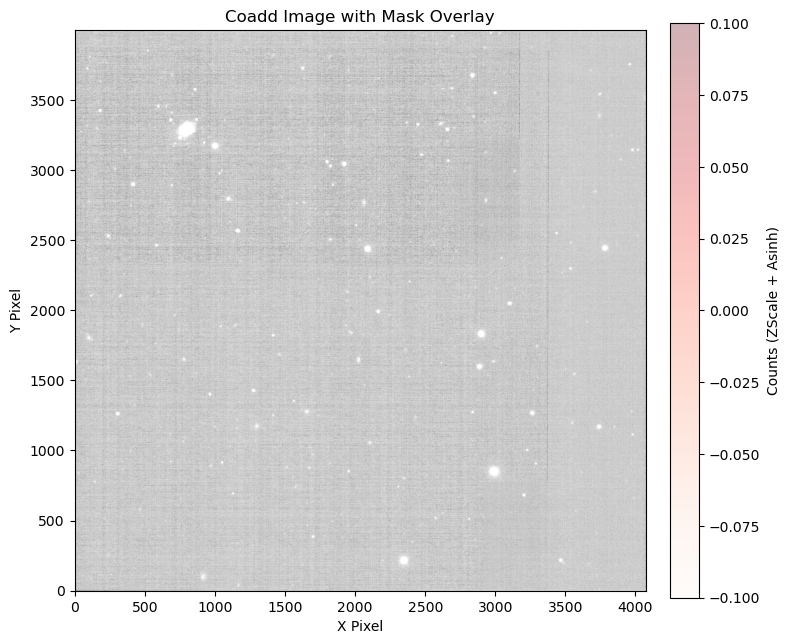

In [31]:
# Coadd Image with Mask Overlay
from astropy.visualization import ZScaleInterval, AsinhStretch, ImageNormalize

# Normalization using ZScale + Asinh
norm = ImageNormalize(image_array, interval=ZScaleInterval(), stretch=AsinhStretch())

# Create figure
plt.figure(figsize=(8, 8))

# Display coadd image with normalization and gray colormap
plt.imshow(image_array, origin='lower', cmap='gray', norm=norm)

# Overlay semi-transparent mask (red)
mask_overlay = np.where(mask_array > 0, 1, np.nan)
plt.imshow(mask_overlay, origin='lower', cmap='Reds', alpha=0.3)

# Colorbar and labels
plt.colorbar(label=r"Counts (ZScale + Asinh)", fraction=0.046, pad=0.04)
plt.title(r"Coadd Image with Mask Overlay")
plt.xlabel(r"X Pixel")
plt.ylabel(r"Y Pixel")
plt.tight_layout()
plt.show()